# Assignment 2: Model Creation with SciKit-learn

In this notebook, you will work through a series of exercises designed to deepen your understanding of model creation using SciKit-learn. The assignment requires code-based solutions—**manually computed or hard-coded results will not be accepted**. 

### Instructions:
- Write your solutions in the provided cells without altering or removing the test cells.
- Upon completion, submit the notebook in **.ipynb** format through Moodle.

In addition to the coding exercises, there are several open-ended questions that require thoughtful responses. Your answers should be thoroughly **justified** using: (a) Python code, (b) performance metrics, and (c) visualizations. Unsubstantiated responses will receive lower evaluations, so ensure your answers are supported with clear evidence.

In [1]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
# Do not add any cells before this one.
# This cell must remain as the first cell in your notebook for proper functionality.


<div class="alert alert-warning">

The following cell contains two functions for result visualization. **DO NOT MODIFY** them.

You are allowed to reuse parts of this code for the open-ended questions,  but ensure both functions remain unchanged in their original form.

- The `plot_decision_surface` function generates a scatter plot of the training data (as circles) and test data (as diamonds), along with the model's decision boundary.
  
- The `plot_parallel_coordinates` function visualizes the accuracy, precision, recall, and F1-score in relation to the gamma parameter of a Support Vector Machine classifier.
</div>

In [2]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import set_config
import plotly.graph_objects as go

set_config(transform_output="pandas")

def plot_decision_surface(X_train, y_train, X_test=None, y_test=None, model=None, show_points=True, title=None):
    if X_train.shape[1] != 2:
        raise ValueError(f'Incorrect shape {X.shape}, can only plot 2D datasets')

    # just plot the dataset first
    cm = 'coolwarm'
    cm_bright = ListedColormap(['#0000FF', '#FF0000', ])

    fig, ax = plt.subplots()

    if model is not None:
        x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
        y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        X_mesh = np.c_[xx.ravel(), yy.ravel()]
        try:
            Z = model.decision_function(X_mesh)
        except AttributeError:
            try:
                Z = model.predict_proba(X_mesh)[:, 1]
                if Z.min() >= 0:
                    Z = Z * 2 - 1
            except AttributeError:
                Z = model.predict(X_mesh)
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        Z_max = np.abs(Z).max()
        cs_contourf = ax.contourf(xx, yy, Z, levels=10, cmap=cm, alpha=.8, vmin=-Z_max, vmax=Z_max, )
        cs_contour = ax.contour(xx, yy, Z, [-1, 0, 1], linewidths=[1, 2, 1], alpha=0.5,
                                colors=('#0000FF', 'gray', '#FF0000'))

        # Make a colorbar for the ContourSet returned by the contourf call.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cbar = ax.figure.colorbar(cs_contourf, cax=cax)
        # Add the contour line levels to the colorbar
        try:
            cbar.add_lines(cs_contour)
        except Exception:
            pass
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

    if show_points:
        # # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   #edgecolors='k', 
                   alpha=0.25)
        # ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
        #                edgecolors='k', alpha=0.6, s=140)
        if X_test is not None:
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       #edgecolors='k',
                       # s=100,
                       marker='D')

    ax.set_xticks(())
    ax.set_yticks(())

    ax.set_aspect('equal', 'box')
    if title is not None:
        ax.set_title(title)
    plt.show()


def plot_parallel_coordinates(df, svm_models, title):
    df = df.copy()
    with pd.option_context('future.no_silent_downcasting', True):
        df = df.replace({'gamma': {'scale': svm_models['scale']._gamma}})
    dimensions = [
        dict(range=[0, 1],
             label='Accuracy', values=df['accuracy']),
        dict(range=[0, df['gamma'].max()],
             label='Gamma', values=df['gamma']),
        dict(range=[0, 1],
             label='Precision 0', values=df['precision_class_0']),
        dict(range=[0, 1],
             label='Precision 1', values=df['precision_class_1']),
        dict(range=[0, 1],
             label='Recall 0', values=df['recall_class_0']),
        dict(range=[0, 1],
             label='Recall 1', values=df['recall_class_1']),
        dict(range=[0, 1],
             label='F1 0', values=df['f1_class_0']),
        dict(range=[0, 1],
             label='F1 1', values=df['f1_class_1'])
    ]
    if 'dataset_size' in df.columns:
        dimensions.insert(1, dict(range=[0, 2500],
                                   label='Dataset size', values=df['dataset_size'],
                                   tickvals=[250, 2500],
                                   ticktext=['250', '2500']))

    
    fig = go.Figure(
        go.Parcoords(
            line=dict(color=df.index.to_list(), colorscale='Plasma_r', showscale=False),
            dimensions=dimensions
        ))
    fig.update_layout(
        title=title,
        font_size=10
    )
    fig.show()


<div class="alert alert-info"><b>Exercise 1: Synthetic dataset generation</b>

Write code to generate the feature matrix `X` and the target array `y` using the `make_moons` function from the `sklearn.datasets` module with the parameters: `n_samples=250`, `noise=0.1`, and `random_state=42`. After creating the dataset, call `plot_decision_surface(X, y)` to visualize the data distribution.

<br><i>[0.5 points]</i>
</div>
<div class="alert alert-warning">

Python is case-sensitive, so ensure your code matches the required capitalization.

</div>

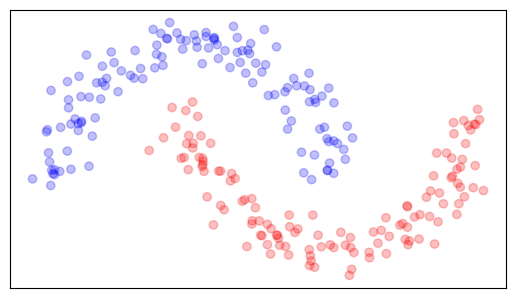

In [3]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=250, noise=0.1, random_state=42)

plot_decision_surface(X, y)



In [4]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 1: Train-test split </b>

Write code to split the generated dataset into training and testing sets, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, `X_test`, `y_train`, and `y_test`. After creating the dataset, call again `plot_decision_surface(X_train, y_train, X_test, y_test)` to visualize the train and test data distribution.
<br><i>[0.25 points]</i>
</div>

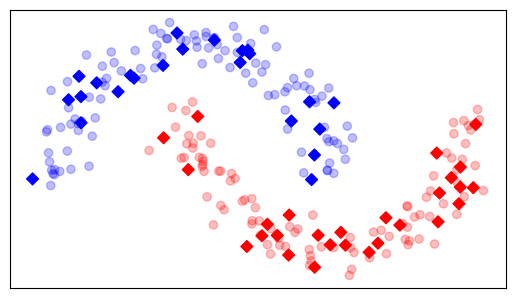

In [5]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=250, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


plot_decision_surface(X_train, y_train, X_test, y_test)

In [6]:
# LEAVE BLANK

In [7]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 2: Logistic regression model creation</b>

Write code to fit a logistic regression model to the training data and store the model in a variable called `logistic`. Then, calculate the accuracy for both the training and testing sets, and store the results in `train_accuracy` and `test_accuracy`, respectively.

<br><i>[0.5 points]</i>
</div>


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, logistic.predict(X_train))

test_accuracy = accuracy_score(y_test, logistic.predict(X_test))

# Output the results
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.855
Testing Accuracy: 0.9


In [9]:
# LEAVE BLANK

In [10]:
# LEAVE BLANK

In [11]:
# LEAVE BLANK

In [12]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 3: Explain logistic regression decision boundary</b>

Provide substantiated answers to the following questions:

- What issues, if any, do you observe in the model’s performance or behavior? Is the decision boundary well-suited to the underlying structure of the data?
- Are there specific areas where the model underperforms? If so, do you believe accuracy alone is an adequate metric to evaluate the model’s performance?
- Do you think logistic regression is an appropriate model for this dataset? Why or why not?
- Does the model appear to overfit or underfit the data? What evidence supports your conclusion?

<br><i>[0.5 points]</i>
</div>

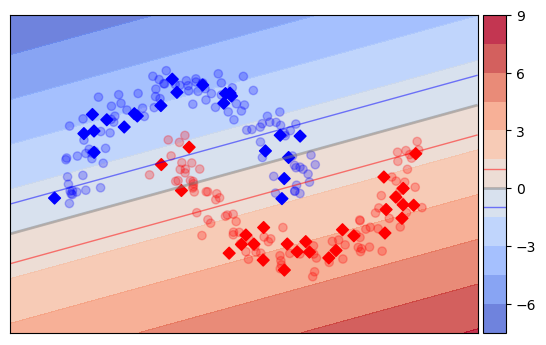

In [13]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, logistic)

What issues, if any, do you observe in the model’s performance or behavior? Is the decision boundary well-suited to the underlying structure of the data?
Are there specific areas where the model underperforms? If so, do you believe accuracy alone is an adequate metric to evaluate the model’s performance?
Do you think logistic regression is an appropriate model for this dataset? Why or why not?
Does the model appear to overfit or underfit the data? What evidence supports your conclusion?

I think that this is a clear example of underfitting as the straight line is not a good representation of the data, which has a clear boundry between the blue and red which can be fit with a curvy line.  I think that relying on accuracy is a bad practice, given how visually, it does not appear to be following the same trend. We clearly need a non-linear model, which can be a decision tree, random forests, or nueral networks. I think the best evidence against this being a bad fit is the fact I can draw a curvy line between both the red and blue dots that has 0 error. 



<div class="alert alert-info"><b>Exercise 4: Decision tree model creation</b>

Write code to fit a decision tree classifier to the training data and store the model in a variable named `dt`. Next, compute the accuracy, precision, and recall for both the training and testing sets, and store the results in the following variables: `train_accuracy`, `train_precision`, `train_recall`, `test_accuracy`, `test_precision`, and `test_recall`.

<br><i>[0.5 points]</i>
</div>

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)


# Calculate metrics directly without storing predictions
train_accuracy = accuracy_score(y_train, dt.predict(X_train))
train_precision = precision_score(y_train, dt.predict(X_train), average='weighted')
train_recall = recall_score(y_train, dt.predict(X_train), average='weighted')

test_accuracy = accuracy_score(y_test, dt.predict(X_test))
test_precision = precision_score(y_test, dt.predict(X_test), average='weighted')
test_recall = recall_score(y_test, dt.predict(X_test), average='weighted')

# Output the results
print("Training Accuracy:", train_accuracy)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)

print("Testing Accuracy:", test_accuracy)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)

Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Testing Accuracy: 0.98
Testing Precision: 0.9807142857142856
Testing Recall: 0.98


In [15]:
# LEAVE BLANK

In [16]:
# LEAVE BLANK

In [17]:
# LEAVE BLANK

In [18]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 5: Explain the decision tree classifier decision boundary</b>

Provide well-supported answers to the following questions:

- Why is the decision tree model a good fit for this dataset?
- Why is the decision boundary of the decision tree seems a heavyside step function? Does this structure contribute to overfitting or underfitting, and can you observe these issues in specific regions of the data?
- How do the decision boundaries produced by decision trees differ from those of logistic regression, particularly when dealing with nonlinear patterns?
- What are the strengths and weaknesses of decision trees compared to logistic regression?

<br><i>[0.75 points]</i>
</div>

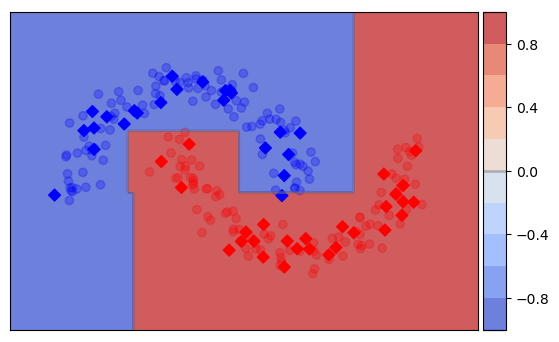

In [19]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, dt)

the decision tree is a good fit for the data as it is clearly non linear, but as we can see the fact that the decision tree splits each part of the graph into rectanglular sections may lead to underfitting in some scenarios. we can see that one of the test dots is in the red, when graphically we can see that line should be slightly lower. The difference with logistic regression is clear, its not a straight line. a clear weakness is the rectangular classifcication, as not many naturally occuring things have the shape of a square or rectangle, even in statistics. the strength is clearly that it is non linear and can see complex patterns. 

<div class="alert alert-info"><b>Exercise 6: Support vector machine model creation </b>

Write code to fit a Support Vector Machine (SVM) classifier with an RBF kernel to the training data and store the model in a variable named `svm`. Then, calculate the accuracy, precision, recall, and F1-score for both the training and testing sets, storing the results in the following variables: `train_accuracy`, `train_precision`, `train_recall`, `test_accuracy`, `test_precision`, `test_recall`, and `test_f1`.

<br><i>[0.5 points]</i>
</div>


In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the SVM classifier with an RBF kernel
svm = SVC(kernel='rbf')

svm.fit(X_train, y_train)

# training set
train_accuracy = accuracy_score(y_train, svm.predict(X_train))
train_precision = precision_score(y_train, svm.predict(X_train), average='weighted')
train_recall = recall_score(y_train, svm.predict(X_train), average='weighted')
train_f1 = f1_score(y_train, svm.predict(X_train), average='weighted')

# testing set
test_accuracy = accuracy_score(y_test, svm.predict(X_test))
test_precision = precision_score(y_test, svm.predict(X_test), average='weighted')
test_recall = recall_score(y_test, svm.predict(X_test), average='weighted')
test_f1 = f1_score(y_test, svm.predict(X_test), average='weighted')

# Output the results
print("Training Accuracy:", train_accuracy)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1)

print("Testing Accuracy:", test_accuracy)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)
print("Testing F1 Score:", test_f1)

Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Training F1 Score: 1.0
Testing Accuracy: 1.0
Testing Precision: 1.0
Testing Recall: 1.0
Testing F1 Score: 1.0


In [21]:
# LEAVE BLANK

In [22]:
# LEAVE BLANK

In [23]:
# LEAVE BLANK

In [24]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 7: Explain the  support vector machine model decision boundary</b>

Provide well-reasoned answers to the following questions:

- Why is the SVM a good fit for this dataset?
- How do support vectors determine the decision boundary, and what impact does this have on the model's effectiveness?
- Why does the SVM produce a smooth, continuous decision boundary, unlike the 'blocky' boundaries seen in decision trees?
- How do the decision boundaries of SVM differ from the linear boundaries of logistic regression?
- What are the strengths and weaknesses of SVM compared to logistic regression and decision trees?
- In what scenarios might logistic regression be more suitable, and when would SVM be a better choice?
- How do support vectors shape the SVM's decision boundary, and how does this differ from the recursive partitioning method used by decision trees?

<br><i>[1 points]</i>
</div>

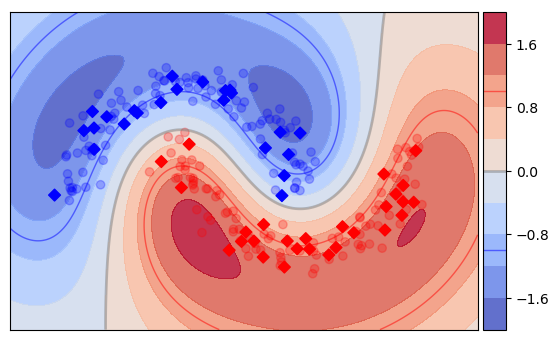

In [25]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, svm)

I think this shows overfitting as not many values are in the super red regions of the data 


<div class="alert alert-info"><b>Exercise 8: Generating a Noisy Dataset</b>

The dataset used in the previous exercies had an easy and well-defined decision boundary. However, real business datasets contains noise and errors, making the classification task more complex and intrincate. To generate a more realistic dataset, write code to generate a new feature matrix `X` and a target array `y` using the `make_moons` function with the parameters: `n_samples=250`, `noise=0.4`, and `random_state=42`. Then, split the generated dataset into training and testing sets, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, `X_test`, `y_train`, and `y_test`. Finally, call again `plot_decision_surface(X_train, y_train, X_test, y_test)` to visualize the new train and test data distribution.

<br><i>[0.25 points]</i>
</div>

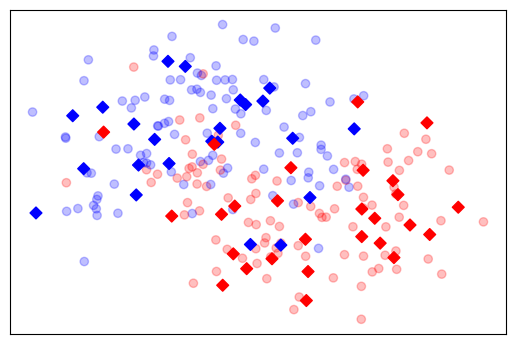

In [26]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generate a more realistic dataset
X, y = make_moons(n_samples=250, noise=0.4, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize the new train and test data distribution
plot_decision_surface(X_train, y_train, X_test, y_test)

In [27]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 9: Analyzing the potential negative impact of noisy datasets</b>

Provide well-supported answers to the following questions:

- How do you think increased noise in the dataset will impact model performance? Which model do you expect to handle noise best, and why?
- How might the logistic regression model be affected by noisy data?
- How do you think noise will influence the decision tree model? Will the step-like characteristic of the boundaries of decision trees become more irregular or over-complicated due to noise? How might this affect performance, especially on unseen data?
- How will the SVM's decision boundary be influenced by noisy data? Do you expect SVM to become more sensitive to noisy data points near the boundary? How might this impact the margin, support vectors, and lead to overfitting or a reduction in margin width?
- What strategies can be used to mitigate the effects of noise on these models?

<br><i>[0.75 points]</i>
</div>

I think that it will clearly affect the mdoel performance, and I think that models with simpler outputs like dts will handle the noise better than models that overfit like svms.

<div class="alert alert-info"><b>Exercise 10: Adding a regularization term</b>

Now, it's time to explore the impact of hyperparameters on model performance. To understand the role of the `gamma` hyperparameter in SVM models, refer to [this resource](https://amagash.github.io/pages/exploration/supervised-learning/svm.html). Additionally, for a general understanding of regularization in supervised learning and SVMs in particular, check out these links: [Simplilearn's guide on regularization](https://www.simplilearn.com/tutorials/machine-learning-tutorial/regularization-in-machine-learning) and [Wikipedia's overview](https://en.wikipedia.org/wiki/Regularization_perspectives_on_support_vector_machines).

Your task is to write a function called `get_metrics(model, X, y)`, where the first parameter is a pre-trained model, `X` is the feature matrix, and `y` is the target array. This function should return a dictionary containing key-value pairs for the following metrics: accuracy, precision for class 0 and class 1, recall for class 0 and class 1, and F1-score for class 0 and class 1. The dictionary should be structured as follows:

```python
{
   'accuracy': accuracy, 
   'precision_class_0': precision_class_0, 
   'precision_class_1': precision_class_1, 
   'recall_class_0': recall_class_0, 
   'recall_class_1': recall_class_1, 
   'f1_class_0': f1_class_0, 
   'f1_class_1': f1_class_1
}
```

Next, train three SVM models using the following values for the `gamma` parameter: `0.01`, `'scale'`, and `100`, while keeping the other hyperparameters at their default values. Store these models in a dictionary called `svm_models`, where each key is the corresponding `gamma` value and the value is the trained model. Use the function `get_metrics(model, X, y)` to generate two DataFrames `train_metrics`, and `test_metrics` to store performance metrics and its corresponding `gamma` value. Finally, find the model with the highest accuracy and store it in a variable called `best_svm`.

<br><i>[1 points]</i>
</div>

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Define the get_metrics function
def get_metrics(model, X, y):
    # Get predictions from the model
    y_pred = model.predict(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision_class_0 = precision_score(y, y_pred, pos_label=0)
    precision_class_1 = precision_score(y, y_pred, pos_label=1)
    recall_class_0 = recall_score(y, y_pred, pos_label=0)
    recall_class_1 = recall_score(y, y_pred, pos_label=1)
    f1_class_0 = f1_score(y, y_pred, pos_label=0)
    f1_class_1 = f1_score(y, y_pred, pos_label=1)
    
    # Return metrics in the specified format
    return {
        'accuracy': accuracy,
        'precision_class_0': precision_class_0,
        'precision_class_1': precision_class_1,
        'recall_class_0': recall_class_0,
        'recall_class_1': recall_class_1,
        'f1_class_0': f1_class_0,
        'f1_class_1': f1_class_1
    }

# Train SVM models with different gamma values
gamma_values = [0.01, 'scale', 100]
svm_models = {gamma: SVC(gamma=gamma).fit(X_train, y_train) for gamma in gamma_values}

# Initialize lists to store metrics data for training and testing
train_metrics_data = []
test_metrics_data = []

# Collect metrics for each model
for gamma, model in svm_models.items():
    # Calculate metrics on the training set
    train_metrics = get_metrics(model, X_train, y_train)
    train_metrics['gamma'] = gamma
    train_metrics_data.append(train_metrics)
    
    # Calculate metrics on the testing set
    test_metrics = get_metrics(model, X_test, y_test)
    test_metrics['gamma'] = gamma
    test_metrics_data.append(test_metrics)

# Convert the metrics data into DataFrames
train_metrics_df = pd.DataFrame(train_metrics_data)
test_metrics_df = pd.DataFrame(test_metrics_data)

# Find the model with the highest test accuracy
best_index = test_metrics_df['accuracy'].idxmax()
best_gamma = test_metrics_df.loc[best_index, 'gamma']
best_svm = svm_models[best_gamma]

# Display the DataFrames and the best model's gamma value
print("Training Metrics DataFrame:")
print(train_metrics_df)
print("\nTesting Metrics DataFrame:")
print(test_metrics_df)
print(f"\nBest model is with gamma={best_gamma}, stored in 'best_svm'")

Training Metrics DataFrame:
   accuracy  precision_class_0  precision_class_1  recall_class_0  \
0     0.775           0.766355           0.784946        0.803922   
1     0.855           0.868687           0.841584        0.843137   
2     0.975           0.961905           0.989474        0.990196   

   recall_class_1  f1_class_0  f1_class_1  gamma  
0        0.744898    0.784689    0.764398   0.01  
1        0.867347    0.855721    0.854271  scale  
2        0.959184    0.975845    0.974093    100  

Testing Metrics DataFrame:
   accuracy  precision_class_0  precision_class_1  recall_class_0  \
0      0.84           0.857143           0.827586        0.782609   
1      0.86           0.833333           0.884615        0.869565   
2      0.70           0.681818           0.714286        0.652174   

   recall_class_1  f1_class_0  f1_class_1  gamma  
0        0.888889    0.818182    0.857143   0.01  
1        0.851852    0.851064    0.867925  scale  
2        0.740741    0.666667    

In [29]:
#pip install pandas==1.0.5

In [30]:
# LEAVE BLANK

In [31]:
# LEAVE BLANK

In [32]:
# LEAVE BLANK

In [33]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 11: Explain SVM regularization effect</b>

Provide well-reasoned answers to the following questions:

- How does adjusting the `gamma` parameter impact the model’s complexity? Which values of `gamma` produce a smoother, more generalized decision boundary, and how does this affect the model's ability to handle noise? Conversely, which values result in a more complex decision boundary that may overfit the data, including noise?
- Can you pinpoint regions where overfitting or underfitting occurs based on the different `gamma` values?
- How do precision and recall vary as you change the `gamma` parameter? Does a higher `gamma` lead to better precision at the expense of recall, or the opposite?
- How do the test set metrics compare to the training set metrics for different `gamma` values? 
- Based on these observations, which model would you select, and why?
- What modifications could be made to improve the chosen model's performance on the noisy dataset?

<br><i>[1 points]</i>
</div>

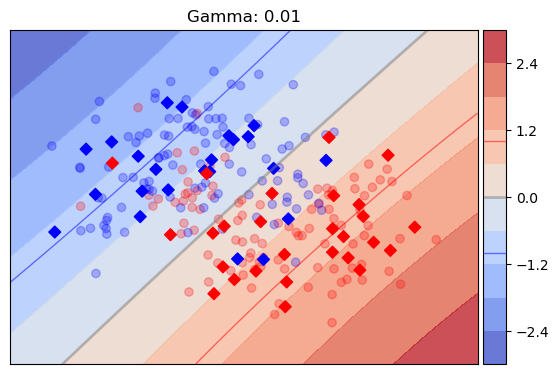

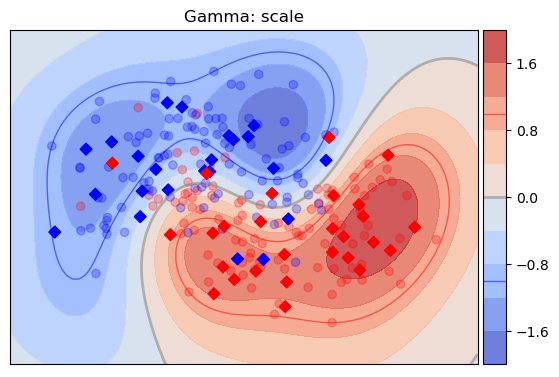

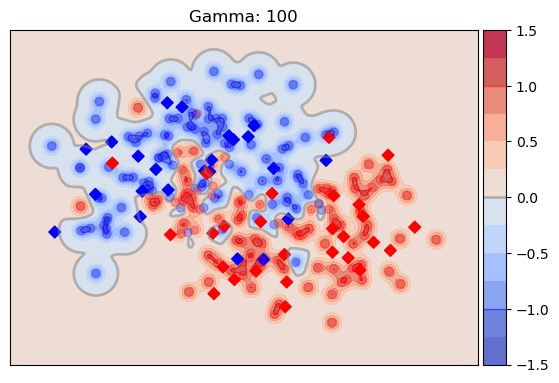

In [34]:
# DO NOT MODIFY THIS CELL. Simply execute it.
for svm in svm_models.values():
    plot_decision_surface(X_train, y_train, X_test, y_test, svm, title=f'Gamma: {svm.gamma}')

In [35]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_parallel_coordinates(train_metrics, svm_models, 'Train metrics')
plot_parallel_coordinates(test_metrics, svm_models, 'Test metrics')


OptionError: No such keys(s): 'future.no_silent_downcasting'

DOUBLE-CLICK AND WRITE YOUR ANSWER HERE

<div class="alert alert-info"><b>Exercise 12: Increase size of dataset</b>

Now, let's retrain the least regularized SVM model with `gamma` set to 100, but this time using a larger dataset. Generate the dataset using the `make_moons` function with the parameters: `n_samples=2500`, `noise=0.4`, and `random_state=42`. Next, split the dataset into training and testing sets, with 80% of the data for training and 20% for testing, ensuring reproducibility by using `random_state=42`. Store the resulting arrays as `X_train`, `X_test`, `y_train`, and `y_test`.

Fit the SVM model using the training data and store it in a variable called `non_regularized_svm`. Then, use the `get_metrics` function to compute the performance metrics, as done in the previous exercise, and append the results to the `train_metrics` and `test_metrics` dataframes.

Finally, add a new column named `dataset_size` to the metrics dataframes, assigning a value of `2500` for the new `non_regularized_svm` model and `250` for the previous models.

<br><i>[1 points]</i>
</div>

In [ ]:
# YOUR CODE HERE

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK


In [ ]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 13: Explain size of dataset</b>

Provide well-reasoned answers to the following questions:

- How does increasing the dataset size help to reduce overfitting and improve the model’s test performance?
- As more data is added, how does the SVM's decision boundary become smoother, allowing the model to generalize better and avoid fitting to noise?
- How do the test metrics (such as accuracy, precision, and recall) improve in relation to the training metrics as the dataset size grows?
- Is there a point where adding more data stops providing significant improvements in performance?
- Why does increasing the dataset size help counterbalance the high `gamma` value, thereby reducing overfitting?
- How does the increase in data help the model create a smoother decision boundary?
- Would you still consider lowering the `gamma` value, or is increasing the dataset size sufficient to address overfitting in this case?
- In which situations might increasing the dataset size alone not be enough to mitigate overfitting, and how could adjusting the `gamma` parameter help in such cases?
- After evaluating the effect of dataset size on overfitting, which model would you choose? Do you believe that increasing the dataset size sufficiently improves the performance of the high-`gamma` model, or would a lower-`gamma` model perform better for this dataset?"

  

<br><i>[1 points]</i>
</div>
<div class="alert alert-warning">

The `plot_decision_surface` function may take up to 30 seconds to complete. Please be patient, this is expected behavior.

</div>


In [ ]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, non_regularized_svm, show_points=False)

In [ ]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_parallel_coordinates(train_metrics, svm_models, 'Train metrics')
plot_parallel_coordinates(test_metrics, svm_models, 'Test metrics')

DOUBLE-CLICK AND WRITE YOUR ANSWER HERE